### Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.utils import plot_model

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

### Загрузка файлов и первичное знакомство с ними

In [ ]:
train_path = '/content/drive/MyDrive/Colab Notebooks/fashion-mnist_train.csv'
test_path = '/content/drive/MyDrive/Colab Notebooks/fashion-mnist_test.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
display(train_data.head())
display(test_data.head())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Создаем словарь, для удобства проверки качества классификации
glossary = {0: 'Футболка', 1: 'Брюки', 2: 'Свитер', 3: 'Платье',
            4: 'Пальто', 5: 'Сандалия', 6: 'Рубашка', 7: 'Кроссовок',
            8: 'Сумка', 9: 'Сапог'}

### Первичная обработка данных

In [ ]:
# Проверяем наличие дубликатов в колонках
duplicates = train_data[train_data.duplicated(keep = False)]
print(f'Число записей: {train_data.shape[0]}')
print(f'Число найденных дубликатов: {duplicates.shape[0]}')
display(duplicates)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(duplicates[i], cmap="Greys")
plt.show()

Число записей: 60000
Число найденных дубликатов: 86


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
601,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
831,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1826,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024,6,0,0,0,0,0,0,0,0,26,...,70,0,0,0,0,0,0,0,0,0
4974,3,0,0,0,0,0,0,0,0,57,...,22,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56657,6,0,0,0,0,0,0,33,110,116,...,94,99,97,88,0,0,0,0,0,0
56840,2,0,0,0,0,0,0,0,1,0,...,0,0,0,201,197,76,0,0,0,0
57107,6,0,0,0,0,0,0,0,0,0,...,60,47,8,0,0,0,0,0,0,0
57724,4,0,0,0,0,0,0,0,0,2,...,0,0,0,145,170,76,0,0,0,0


In [ ]:
# Удаление дубликатов
train_data = train_data.drop_duplicates()
print(f'Результирующее число записей: {train_data.shape[0]}')

Результирующее число записей: 59957


In [ ]:
# Исследование пропусков
cols_null_percent = train_data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(f'Количество колонок с пропусками: {cols_with_null.shape}')

'Количество колонок с пропусками: (0,)'

### Подготока данных к обучению

In [ ]:
# Выделяем целевую переменную и удаляем ее из основного датасета
y_train = train_data['label'].values #берём таргет
train_num = train_data.shape[0]
x_train = train_data.drop(columns='label').values.reshape((train_num, 28, 28))

y_test = test_data['label'].values #берём таргет
test_num = test_data.shape[0]
x_test = test_data.drop(columns='label').values.reshape((test_num, 28, 28))

# Проверка корректности
print(f'Размер обучающей выборки: {x_train.shape}')
print(f'Размер тестовой выборки: {x_test.shape}')

Размер обучающей выборки: (59957, 28, 28)
Размер тестовой выборки: (10000, 28, 28)


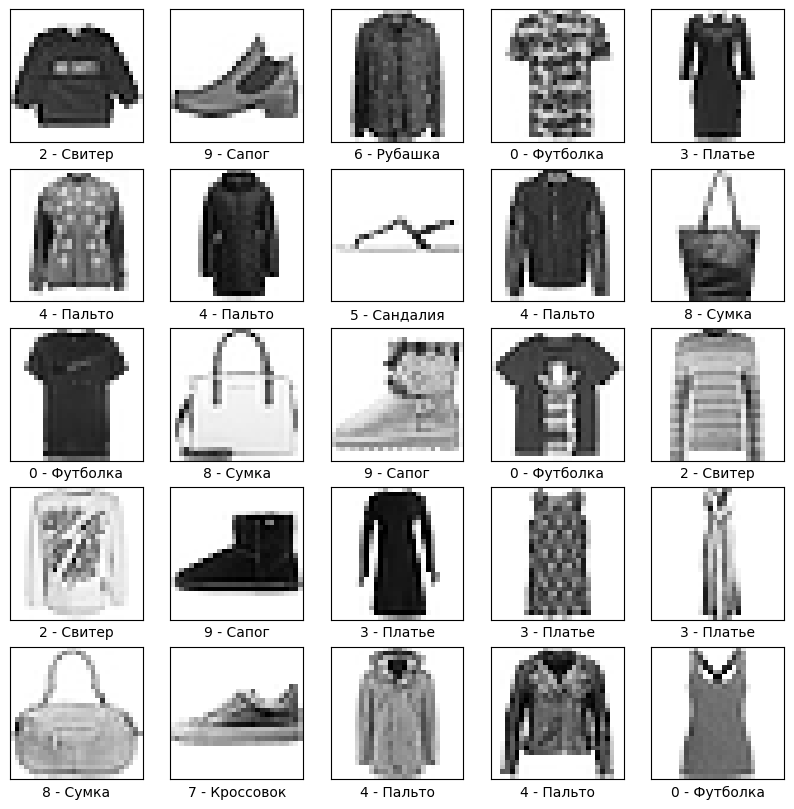

In [ ]:
# Посмотрим примеры картинок для классификации
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap="Greys")
    plt.xlabel(str(y_train[i]) + ' - ' + glossary[y_train[i]])
plt.show()

In [ ]:
# Центрируем и нормируем данные
x_train_float = x_train.astype(float) / 255 - 0.5
x_test_float = x_test.astype(float) / 255 - 0.5
print(x_train_float[1, 1, 10:20])
print(x_test_float[1, 1, 10:20])

[-0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5]
[-0.40588235  0.42156863  0.32352941  0.44509804  0.37058824  0.17058824
  0.3627451   0.28039216  0.4254902  -0.39411765]


In [ ]:
# one-hot encode для ответов
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_test_oh = keras.utils.to_categorical(y_test, 10)

print(y_train_oh.shape)
print(y_train_oh[:5], y_train[:5])

(59957, 10)
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]] [2 9 6 0 3]


### Обучение сети

In [ ]:
clear_session()

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', input_shape=(28, 28, 1)))
model.add(MaxPool2D())
model.add(Conv2D(64, kernel_size=3, strides=1, padding='same'))
model.add(MaxPool2D())
model.add(Conv2D(128, kernel_size=3, strides=1, padding='same'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

In [ ]:
model.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer='adam',
    metrics=['accuracy']  # выводим процент правильных ответов
)

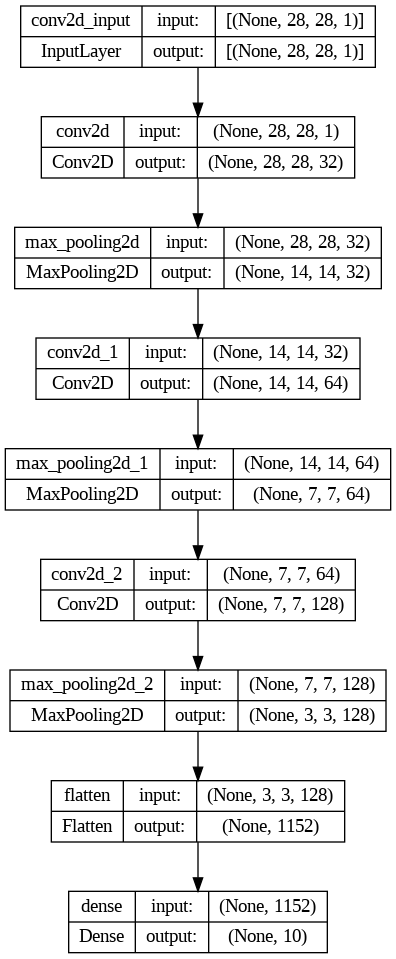

In [ ]:
# Визуализируем модель
plot_model(model, show_shapes = True)

In [ ]:
# Обучаем модель
history = model.fit(
    x_train_float[:, :, :, np.newaxis],
    y_train_oh,
    batch_size=64,
    epochs=5,
    validation_data=(x_test_float[:, :, :, np.newaxis], y_test_oh)
)

Epoch 1/5
937/937 [==============================] - 94s 99ms/step - loss: 0.4596 - accuracy: 0.8351 - val_loss: 0.3226 - val_accuracy: 0.8857
Epoch 2/5
937/937 [==============================] - 92s 99ms/step - loss: 0.3012 - accuracy: 0.8919 - val_loss: 0.2934 - val_accuracy: 0.8967
Epoch 3/5
937/937 [==============================] - 106s 114ms/step - loss: 0.2576 - accuracy: 0.9081 - val_loss: 0.2615 - val_accuracy: 0.9068
Epoch 4/5
937/937 [==============================] - 94s 101ms/step - loss: 0.2255 - accuracy: 0.9185 - val_loss: 0.2617 - val_accuracy: 0.9046
Epoch 5/5
937/937 [==============================] - 96s 102ms/step - loss: 0.1974 - accuracy: 0.9288 - val_loss: 0.2476 - val_accuracy: 0.9131


### Получение предсказания и оценка точности модели

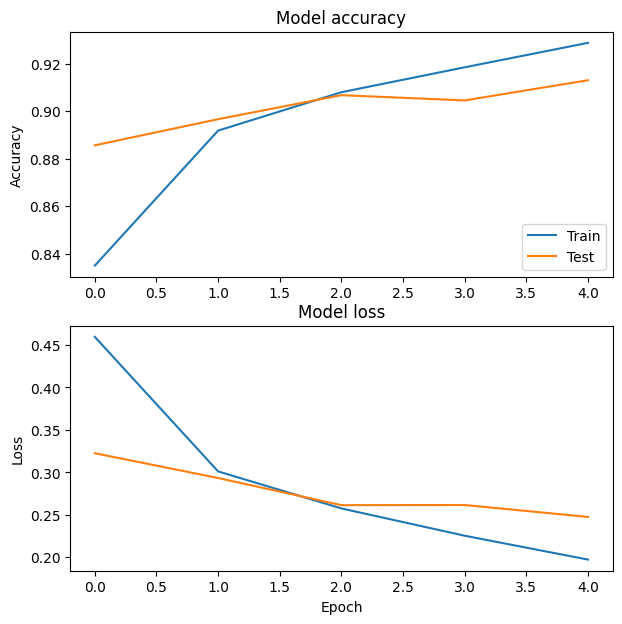

In [ ]:
# Построим график точности в зависимости от эпохи
plt.style.use(['default'])
fig, ax = plt.subplots(figsize=(7,7), nrows=2, ncols=1)
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Test'], loc='lower right')

# Построим график потерь в зависимости от эпохи
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
plt.show()

In [ ]:
# Сделаем предсказание на тестовых данных
predicts=model.predict(x_test_float)
classes_x=np.argmax(predicts,axis=1)

# Посмотрим на точность предсказания на тестовых данных
print('Test Accuracy: ', accuracy_score(y_test, classes_x))

313/313 [==============================] - 5s 14ms/step
Test Accuracy:  0.9131


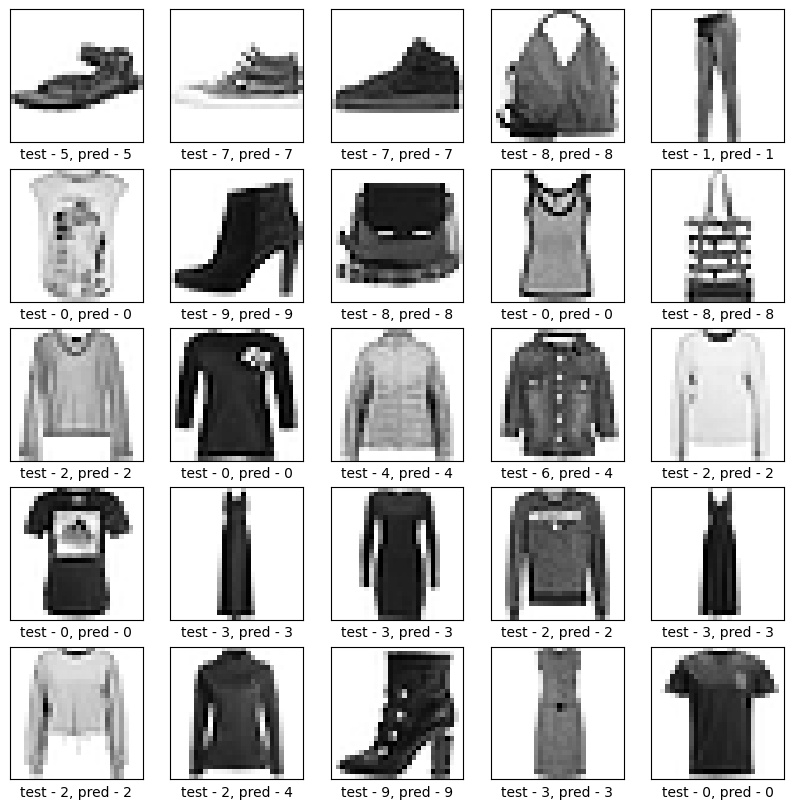

In [ ]:
# Посмотрим на качество классификации
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i+30], cmap="Greys")
    x_lab = 'test - ' + str(y_test[i+30]) + ', pred - ' + str(classes_x[i+30])
    plt.xlabel(x_lab)
plt.show()

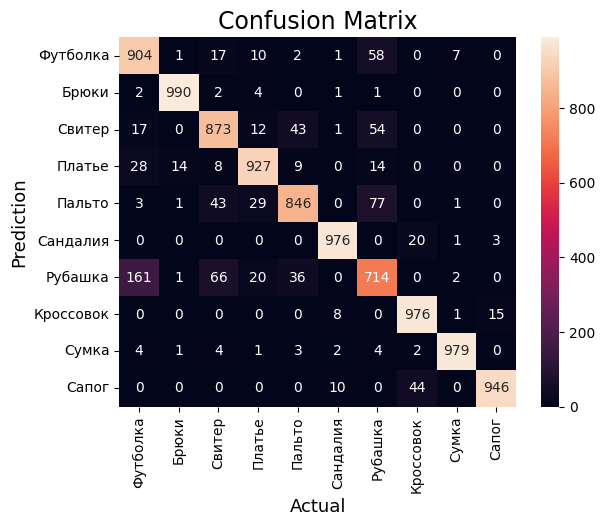

In [ ]:
cloth_name = ['Футболка', 'Брюки', 'Свитер', 'Платье', 'Пальто',
              'Сандалия', 'Рубашка', 'Кроссовок', 'Сумка', 'Сапог']
con_mat = confusion_matrix(y_test, classes_x)
sns.heatmap(con_mat,
            annot=True,
            fmt='g',
            xticklabels=cloth_name,
            yticklabels=cloth_name)
plt.ylabel('Prediction', fontsize=13)
plt.xlabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17)
plt.show()

In [ ]:
# Сохраним полученное предсказание
id = np.arange(y_test.shape[0])
result = pd.DataFrame({
    'Id': id,
    'Category': classes_x
})
result_path = '/content/drive/MyDrive/Colab Notebooks/result.csv'
result.to_csv(result_path, index=False)